### 1. INSTALLING AND IMPORTING LIBRARY PACKAGES

In [1]:
import warnings
warnings.filterwarnings('ignore')
!pip install librosa
!pip install gap_stat
!pip install audiomentations

In [6]:
import random
from librosa import feature
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import soundfile as sf
import librosa
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighPassFilter


import numpy as np
import pandas as pd


### 2. BUILDIN DATASET

#### Data Augmentation- Audio Files

In [32]:
def frequency_modulation(audio, freq_mod_rate):
    return librosa.effects.time_stretch(audio, freq_mod_rate)

def pitch_shift(audio, audiorate, num_semitones):
    return librosa.effects.pitch_shift(audio, audiorate, num_semitones)

def amplitude_modulation(audio, min_factor=0.1, max_factor=0.12):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_audio = audio * gain_rate
    return augmented_audio

In [33]:
#    audio, a_rate = librosa.load("C:/Users/vpara/Documents/12.GTZAN-Genre-Collection/genres/blues/blues.00000.au")
#    augmented_audio_fm = frequency_modulation(audio,0.8)
#    sf.write("C:/Users/vpara/Documents/12.GTZAN-Genre-Collection/genres/blues/augmented_tm_blues.00000.au", augmented_signal_fm, a_rate)
#    augmented_audio_ps = pitch_shift(audio,a_rate,2)
#    sf.write("C:/Users/vpara/Documents/12.GTZAN-Genre-Collection/genres/blues/augmented_ps_blues.00000.au", augmented_signal_ps, a_rate)
#    augmented_audio_am = amplitude_modulation(audio,2,4)
#    _plot_signal_and_augmented_signal(audio, augmented_signal_am, a_rate)

In [3]:
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop'] #, 'jazz', 'metal', 'pop', 'reggae', 'rock']

def audio_data_augmentation(genres=GENRES,PATH_STRING ="C:/Users/vpara/Documents/12.GTZAN-Genre-Collection/genres/"):    
    for genre in genres:
        for filename in os.listdir(f"{PATH_STRING}{genre}"):
            file_path = os.path.join(f"{PATH_STRING}{genre}",filename)
            audio, a_rate = librosa.load(file_path)
            
            augmented_audio_fm = frequency_modulation(audio,0.8)
            filename_aug_fm = "augmented_fm_" + filename
            file_path_aug_fm = os.path.join(f"{PATH_STRING}{genre}",filename_aug_fm)
            sf.write(file_path_aug_fm, augmented_audio_fm, a_rate)
            
            augmented_audio_ps = pitch_shift(audio,a_rate,2)
            filename_aug_ps = "augmented_ps_" + filename
            file_path_aug_ps = os.path.join(f"{PATH_STRING}{genre}",filename_aug_ps)           
            sf.write(file_path_aug_ps, augmented_audio_ps, a_rate)            
            
            augmented_audio_am = amplitude_modulation(audio,2,4)            
            filename_aug_am = "augmented_am_" + filename
            file_path_aug_am = os.path.join(f"{PATH_STRING}{genre}",filename_aug_am)           
            sf.write(file_path_aug_am, augmented_audio_am, a_rate)                        
            
            #augmented_audio_ip = invert_polarity(audio)          # uncomment to generate 100 more files for each genre by inverting polarity
            #sf.write("C:/Users/vpara/Documents/12.GTZAN-Genre-Collection/genres/blues/augmented_rg_blues.00000.au", augmented_audio_ip, a_rate)
            #_plot_signal_and_augmented_signal(audio, augmented_audio_ip, a_rate)           


In [35]:
#audio_data_augmentation()

In [4]:
def audio_values(genres=GENRES,path ="C:/Users/vpara/Documents/12.GTZAN-Genre-Collection/genres/"):    
    songs = []
    for genre in genres:
        genre_files = []
        for f_name in os.listdir(f"{path}{genre}"):
            genre_files.append(sf.read(os.path.join(f"{path}{genre}",f_name)))
        songs.append(genre_files)
    return songs

In [7]:
songs = audio_values()

In [16]:
def audio_descriptors(songs=songs):

    A = 128 
    B = 12

    global artbtry_matrix
    artbtry_matrix = np.random.rand(B,A)
    descriptor = np.zeros((1,2*B+1))
    for g_class, genre in enumerate(songs):
        for song, a_rate in genre:
            spectrogram = feature.melspectrogram(y=song,sr=a_rate)            
            dot = np.dot(artbtry_matrix, spectrogram) 
            artbtry_features = np.array([g_class])
            for descp in dot:
                artbtry_features = np.hstack([np.array([descp.mean(),np.std(descp)]),artbtry_features])
            artbtry_features = np.array(artbtry_features)
            descriptor = np.vstack([descriptor,artbtry_features])

    return pd.DataFrame(data=descriptor).drop(0).reset_index(drop=True)


In [17]:
audio_data = audio_descriptors()
audio_data

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,149.559610,152.721893,121.813939,111.514656,123.511578,146.508333,107.890194,127.813183,133.469161,159.074577,...,155.842689,143.402356,142.180969,129.034817,149.999184,139.973400,149.344155,140.168949,179.441038,0.0
1,87.948169,91.102440,76.041944,72.199446,68.856141,67.528465,53.126806,56.608094,80.003848,79.891980,...,62.389717,90.016038,86.440263,67.890216,67.940063,76.890613,76.254523,89.211026,88.383795,0.0
2,236.006090,151.888713,198.864972,128.717956,202.549562,127.901255,173.697873,116.402096,200.647558,127.302972,...,125.877447,249.351698,156.751944,204.031144,142.585465,195.404566,134.664752,213.283310,140.269445,0.0
3,199.567503,240.719268,183.941311,262.381599,219.090968,333.170534,137.380555,177.349966,207.725083,284.435013,...,179.008786,227.471002,283.746083,145.847426,167.631838,100.420122,97.747089,313.935532,464.239504,0.0
4,63.737153,73.057606,60.879650,70.470496,66.204403,70.635890,58.488513,68.286253,52.523302,57.520095,...,72.676939,56.422634,59.262114,58.958259,69.739056,62.211278,64.245611,53.796749,59.766908,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,98.275307,48.382818,89.629346,44.612291,79.041115,47.122036,74.667779,39.101672,98.348034,50.052356,...,38.418167,113.140635,54.719687,84.559889,44.558824,85.484356,44.425821,105.766434,54.012061,9.0
2016,88.407614,57.419311,91.938569,60.643458,82.939040,53.121901,58.505173,37.551213,84.876023,52.763562,...,47.432539,103.247986,64.838738,77.922912,53.939883,81.248422,55.898318,97.698817,62.284027,9.0
2017,98.073305,50.718517,87.660787,45.143277,78.395206,40.699646,64.934304,35.226509,84.246255,45.951250,...,39.451125,109.231769,55.325369,80.863123,42.542641,81.301378,40.216854,95.319840,53.284936,9.0
2018,142.061403,91.816425,130.977477,93.643822,113.665945,89.459665,79.387657,59.169122,111.399641,80.091879,...,60.296234,147.114141,94.688264,115.234713,76.848063,95.728619,61.841664,154.559030,112.407315,9.0


In [18]:
audio_data.to_csv("C:/Users/vpara/Documents/12.GTZAN-Genre-Collection/AudioDataset_5 Classifications_400 Samples Each.csv")

In [19]:
# shuffle dataset
audio_data = audio_data.sample(frac=1).reset_index(drop=True)

### 3. EXPLORING DATA AND DIMENTIONALITY REDUCTION

In [20]:
features,labels = audio_data.values[:,:-1], audio_data.values[:,-1]

##### 3.1 Plot Cumulative Variance

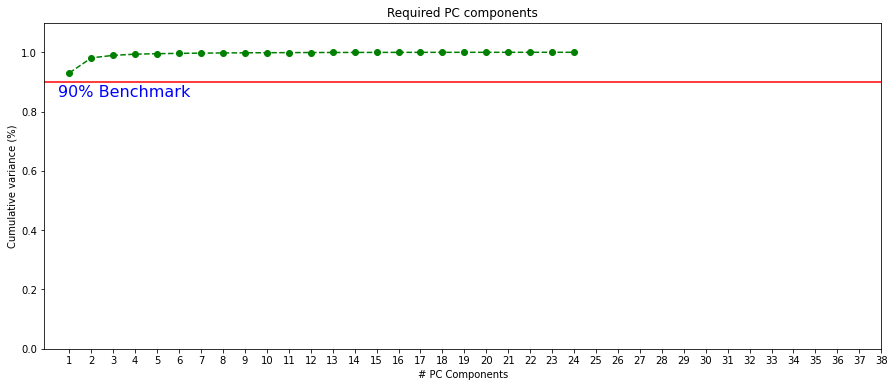

In [22]:
normalization = StandardScaler()
pca_norm = normalization.fit_transform(features)
pca = PCA()
pca_model = pca.fit_transform(pca_norm)
# Plot the cumulative variance for each component
plt.figure(figsize = (15, 6))
PC_Components = np.arange(1, 25, step=1)
Data_variance = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(PC_Components, Data_variance, marker='o', linestyle='--', color='green')
plt.xlabel('# PC Components')
plt.xticks(np.arange(1, 39, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Required PC components')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.85, '90% Benchmark', color = 'Blue', fontsize=16)
plt.show()

##### 3.2 Construct PCA Load Matrix Dataframe based on number of PCA Components

From the above cummulative variance plot the number of PC components can be only two, infact only one is required. But for a 
precise note the 100% data variance is utilised and not just above 90%. Thus reduced the number of features from 23 to four.

For a <b>research basis</b> the PCA svd solver{‘auto’, ‘full’, ‘arpack’, ‘randomized’} shall be given the priority.

In [23]:
pca = PCA(n_components=4,svd_solver = 'auto')
Principal_components=pca.fit_transform(features)
pca_features = pd.DataFrame(data = Principal_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
pca_labels = pd.DataFrame(data = labels, columns = ['Labels'])
pca_features_labels = pd.concat([pca_features, pca_labels], axis=1)
pca_features_labels['Labels'] = pca_features_labels['Labels'].astype(int)
print(pca_features_labels)

              PC 1         PC 2        PC 3        PC 4  Labels
0      5153.104340  -474.283647 -191.280924 -135.671024       9
1     10284.069903 -1666.667715  632.584027 -420.029186       8
2     -1252.727170   164.359016   12.139461  -36.877824       7
3     -1012.356086  -221.260838   98.394429   18.216985       7
4       200.673260   264.334036  -96.217879  -46.739159       2
...            ...          ...         ...         ...     ...
2015  -1506.625628   -23.556949  -26.112819  -17.712688       3
2016  10690.421343 -2807.748417 -974.886498  364.449053       0
2017   -660.093658   -94.688006  177.783776 -155.040041       3
2018  -1167.676977   -50.941553  -13.021666  -15.747193       7
2019  -2175.402941   113.140999   34.709814   -6.553419       0

[2020 rows x 5 columns]


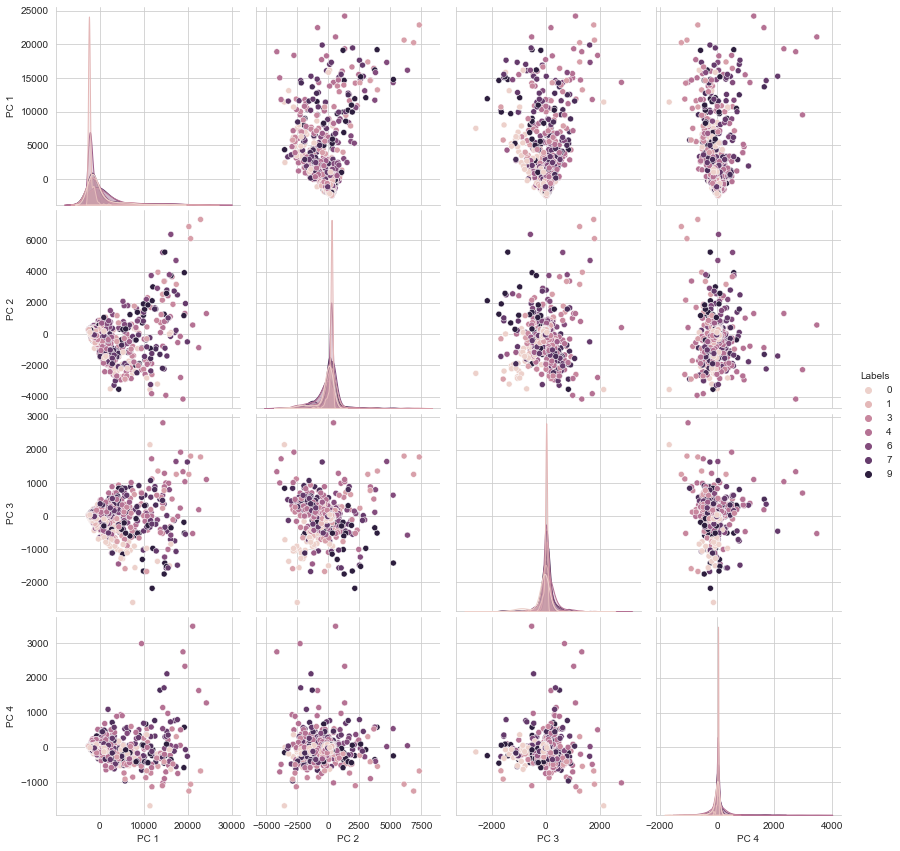

In [24]:
plt.close();
sns.set_style('whitegrid');
sns.pairplot(pca_features_labels, hue='Labels', height=3);
plt.show()

### 4. FINDING OPTIMAL K-VALUE FOR KNN

##### 4.1 Elbow Method

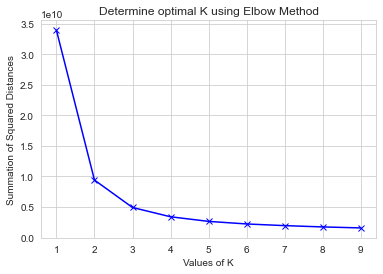

In [25]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(pca_features)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Summation of Squared Distances') 
plt.title('Determine optimal K using Elbow Method')
plt.show()

##### 4.2 Gap Statistic Method

In [26]:
from gap_statistic import OptimalK
from sklearn.cluster import KMeans
def KMeans_cluster(X, k): 
    m = KMeans(random_state=11, n_clusters=k)
    m.fit(X)
    return m.cluster_centers_, m.predict(X)
K_value = OptimalK(clusterer=KMeans_cluster)
n_clusters = K_value(pca_features, cluster_array=np.arange(1, 15))
K_value.gap_df[['n_clusters', 'gap_value']]

,n_clusters,gap_value
0,1.0,1.507180
1,2.0,1.879106
2,3.0,2.217508
3,4.0,2.427838
4,5.0,2.519369
5,6.0,2.529270
6,7.0,2.535999
7,8.0,2.548454
8,9.0,2.572494
9,10.0,2.605078


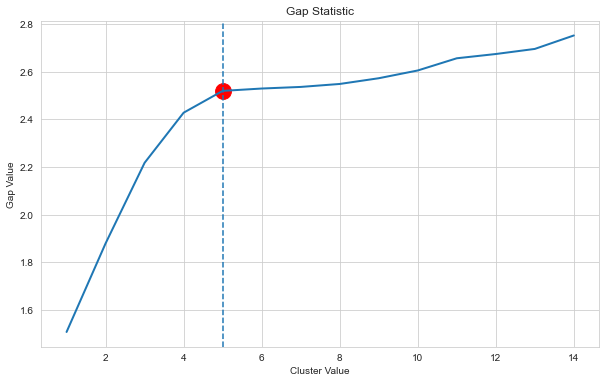

In [29]:
plt.figure(figsize=(10,6))
n_cluster=5
plt.plot(K_value.gap_df.n_clusters, K_value.gap_df.gap_value, linewidth=2)
plt.scatter(K_value.gap_df[K_value.gap_df.n_clusters == n_cluster].n_clusters,
            K_value.gap_df[K_value.gap_df.n_clusters == n_cluster].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Value')
plt.ylabel('Gap Value')
plt.title('Gap Statistic')
plt.axvline(5, linestyle="--")
plt.show()

##### 4.3 Silhouette Method

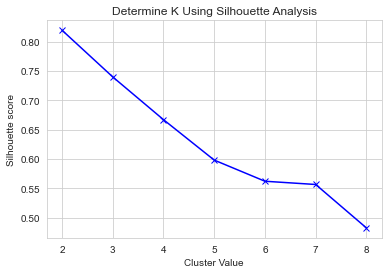

In [32]:
n_cluster = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in n_cluster:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(pca_features)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(pca_features, cluster_labels))
plt.plot(n_cluster,silhouette_avg,'bx-')
plt.xlabel('Cluster Value') 
plt.ylabel('Silhouette score') 
plt.title('Determine K Using Silhouette Analysis')
plt.show()

### 5. BUILDING THE MODEL

In [33]:
Features,Labels = pca_features_labels.values[:,:-1], pca_features_labels.values[:,-1]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = 0.20, random_state = 42)
classifier = KNeighborsClassifier(n_neighbors = 2, algorithm ='ball_tree', metric = 'minkowski', p = 5)
classifier.fit(X_train, y_train)
ypred=classifier.predict(X_train)

#### 5.1 Train Accuracy

In [35]:
cm = confusion_matrix(y_train, ypred)
print('Confusion Matrix:')
print(cm)
cr = classification_report(y_train, ypred)
print('Classification Report:')
print (cr)
Metric_Train = accuracy_score(y_train,ypred)
print('Accuracy:',Metric_Train)

Confusion Matrix:
[[156   0   0   0   0   0   0   0   0   0]
 [ 12 146   0   0   0   0   0   0   0   0]
 [ 16   4 141   0   0   0   0   0   0   0]
 [ 12   3  11 135   0   0   0   0   0   0]
 [  4   0   3  20 140   0   0   0   0   0]
 [ 14  30  33   4   3  86   0   0   0   0]
 [ 12   1   9   9   4   9 105   0   0   0]
 [ 15   1   7  16  23   4   6  95   0   0]
 [  7   2   6  23  20   4   3  20  83   0]
 [  6   3  22  15   7   7  26  15  11  47]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76       156
         1.0       0.77      0.92      0.84       158
         2.0       0.61      0.88      0.72       161
         3.0       0.61      0.84      0.70       161
         4.0       0.71      0.84      0.77       167
         5.0       0.78      0.51      0.61       170
         6.0       0.75      0.70      0.73       149
         7.0       0.73      0.57      0.64       167
         8.0       0.88      0.49      0.

#### 5.2 Prediction And Test Accuracy

In [36]:
ypred=classifier.predict(X_test)
Metric_Test = accuracy_score(y_test,ypred)
print('Accuracy:',Metric_Test)

Accuracy: 0.3564356435643564


#### 5.3 Hyperparameter Tuning- Grid Search 

In [40]:
grid_size = list(range(1,500))
n_cluster = list(range(1,3))
p=[1,2]

hyperparameters = dict(leaf_size=grid_size, n_neighbors=n_cluster, p=p)
GS = GridSearchCV(classifier, hyperparameters, cv=20)

best_model = GS.fit(X_train,y_train)

ypred = best_model.predict(X_test)

Metric_HT = accuracy_score(y_test,ypred)
print('Accuracy:',Metric_HT)

Accuracy: 0.42574257425742573


### THE END